In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import random
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten,Embedding
from keras.layers import Activation, Conv1D, GlobalMaxPooling1D
from keras import optimizers
from keras import layers
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


In [2]:
URL_Train= "https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv"

#load data
train=pd.read_csv(URL_Train,sep='\t')
print(len(train))
train.head()

156060


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


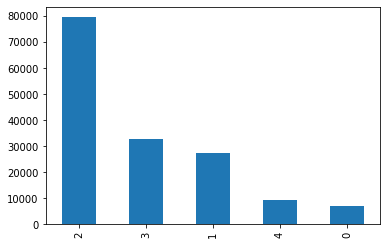

In [3]:
phrase = train['Phrase']
sentiment = train['Sentiment']
sentiment.value_counts().plot(kind='bar')

In [4]:
fullSentences = []
curSentence = 0
for i in range(train.shape[0]):
  if train['SentenceId'][i]> curSentence:
    fullSentences.append((train['Phrase'][i], train['Sentiment'][i]))
    curSentence = curSentence +1

# put data into a df
fullSentDf = pd.DataFrame(fullSentences,
                                columns=['Phrase', 'Sentiment'])
print(fullSentDf['Sentiment'].value_counts())
print(fullSentDf['Phrase'][1])

3    2325
1    2203
2    1659
4    1282
0    1075
Name: Sentiment, dtype: int64
This quiet , introspective and entertaining independent is worth seeking .


In [0]:
from nltk.tokenize import word_tokenize

documents = []
#convert data into format for the previous labs

#use full dataset
#for i in range(data.shape[0]):
#  tmpWords = word_tokenize(data['Phrase'][i])
#  documents.append((tmpWords, data['Sentiment'][i]))

# Use only complete sentences
for i in range(fullSentDf.shape[0]):
  tmpWords = word_tokenize(fullSentDf['Phrase'][i])
  documents.append((tmpWords, fullSentDf['Sentiment'][i]))

In [0]:
porter = PorterStemmer()
lancaster=LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
StopWords = stopwords.words("english")
punctuations="?:!.,;'\"-()"
#parameters to adjust to see the impact on outcome
remove_stopwords = True
useStemming = True
useLemma = False
removePuncs = True
# print(StopWords)

for l in range(len(documents)): #For each review docu-ment
  # print(l)
  label = documents[l][1] #Save review label
  tmpReview = [] #Placeholder list for new review
  # train_new=[]
  for w in documents[l][0]: #For each word this is review
    newWord = w #Set newWork to be the updated word
    if remove_stopwords and (w in StopWords):#if the word is a stopword 
      continue #skip the word and don’t had it to the normalized review
    if removePuncs and (w in punctuations):#if the word is a punc
      continue #skip the word and don’t had it to the normalized review
    if useStemming: #if useStemming is set to True
      #Keep one stemmer commented out
      #newWord = porter.stem(newWord) #User porter stemmer
      newWord = lancaster.stem(newWord) #Use Lancaster stemmer
    if useLemma:
      newWord = wordnet_lemmatizer.lemmatize(newWord)
    tmpReview.append(newWord) #Add normalized word to the tmp review
  documents[l] = (' '.join(tmpReview), label)
# print(documents[2]) #Update the reviews list with clean review

In [8]:
## Splitting the training and testing data

X_train, X_test, y_train, y_test = train_test_split(train['Phrase'], 
                                                    train['Sentiment'], 
                                                    test_size=0.3, 
                                                    random_state=2003)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(109242,)
(46818,)
(109242,)
(46818,)


In [0]:
from keras.preprocessing.text import Tokenizer
NB_WORDS = 5000
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", 
                                   ngram_range=(1, 1), 
                                   max_features = 5000)

train_tfid = tfidf_vectorizer.fit_transform(X_train)
train_tfid = np.array(train_tfid.toarray())

test_tfid = tfidf_vectorizer.fit_transform(X_test)
test_tfid = np.array(test_tfid.toarray())

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [10]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    109242.000000
mean          7.194595
std           7.011804
min           1.000000
25%           2.000000
50%           5.000000
75%          10.000000
max          52.000000
Name: Phrase, dtype: float64

In [0]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 51
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)
# X_train_seq_trunc[15]  # Example of padded sequence

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [13]:
print(y_train.shape)
print(y_test.shape)
print(y_train_oh.shape)
print(y_test_oh.shape)

(109242,)
(46818,)
(109242, 5)
(46818, 5)


In [14]:
# Splitting the validation data
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, 
                                                                      y_train_oh, 
                                                                      test_size=0.1, 
                                                                      random_state=2003)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (10925, 51)


In [0]:
# Functions used to get the performnce of the model
def recall_m(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0,1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0,1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision= precision_m(y_true, y_pred)
  recall= recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
from keras import models
from keras import layers
from keras import regularizers
##### Model ######
Model = models.Sequential()
Model.add(layers.Embedding(NB_WORDS, 5, input_length=MAX_LEN))
Model.add(Conv1D(filters=100, kernel_size=2, activation= 'relu'))
Model.add(MaxPooling1D(pool_size=2))
Model.add(Conv1D(filters=100, kernel_size=2, activation= 'relu'))
Model.add(MaxPooling1D(pool_size=2))
Model.add(layers.Flatten())
Model.add(layers.Dense(5, activation='softmax'))
Model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 51, 5)             25000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 100)           1100      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 100)           20100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)            

In [17]:
#Save the trained model

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

Model.save('1093483_SentimentAnalysis.h5')
Model_file = drive.CreateFile({'title' : '1093483_SentimentAnalysis.h5'})                       
Model_file.SetContentFile('1093483_SentimentAnalysis.h5')                       
Model_file.Upload()

# download to google drive                       
drive.CreateFile({'id': Model_file.get('id')})

GoogleDriveFile({'id': '1J_6Oyu50QGE-AC7svA1aoEm2-7xkRxSR'})

In [18]:
# Initializing the parameters
lr=1e-4
decay=1e-4
num_epochs=100
adm = optimizers.Adam(lr=lr, decay=decay)

# Compile & Fit the model
Model.compile(optimizer=adm,
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m,recall_m])

t1=time.time()
history_train = Model.fit(X_train_emb,
                    y_train_emb,
                    epochs=num_epochs,
                    batch_size=128,
                    validation_data=(X_valid_emb,y_valid_emb))
t2=time.time()
t3=t2-t1
print('Training Time:',np.round(t3,2),'seconds')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 98317 samples, validate on 10925 samples
Epoch 1/100
98317/98317 [==============================] - 10s 104us/step - loss: 1.2894 - acc: 0.5121 - f1_m: 0.4001 - precision_m: 0.4927 - recall_m: 0.3414 - val_loss: 1.2389 - val_acc: 0.5051 - val_f1_m: 0.4515 - val_precision_m: 0.6354 - val_recall_m: 0.3511
Epoch 2/100
98317/98317 [==============================] - 3s 35us/step - loss: 1.2104 - acc: 0.5190 - f1_m: 0.4753 - precision_m: 0.6427 - recall_m: 0.3780 - val_loss: 1.2076 - val_acc: 0.5149 - val_f1_m: 0.4706 - val_precision_m: 0.6564 - val_recall_m: 0.3677
Epoch 3/100
98317/98317 [==============================] - 3s 35us/step - loss: 1.1744 - acc: 0.5300 - f1_m: 0.4876 - precision_m: 0.6769 - recall_m: 0.3820 - val_loss: 1.1691 - val_acc: 0.5305 - val_f1_m: 0.4782 - val_precision_m: 0.6946 - val_recall_m: 0.3658
Epoch 4/100
98317/98317 [==============================] - 3s 35

In [19]:
#Test Model
history_test= Model.fit(X_train_seq_trunc,
              y_train_oh,
              epochs=num_epochs,
              batch_size=128,
              verbose=1)

# Evaluate the model
loss, accuracy, f1_score, precision, recall = Model.evaluate(X_test_seq_trunc, y_test_oh)

print('\nTest accuracy : {0:.2f}%'.format(accuracy*100))
print('\nf1 : {0:.2f}%'.format(f1_score*100))
print('\nprecision : {0:.2f}%'.format(precision*100))
print('\nrecall : {0:.2f}%'.format(recall*100))

Epoch 1/100
109242/109242 [==============================] - 4s 35us/step - loss: 0.8559 - acc: 0.6614 - f1_m: 0.6404 - precision_m: 0.6979 - recall_m: 0.5920
Epoch 2/100
109242/109242 [==============================] - 4s 35us/step - loss: 0.8552 - acc: 0.6611 - f1_m: 0.6404 - precision_m: 0.6984 - recall_m: 0.5916
Epoch 3/100
109242/109242 [==============================] - 4s 34us/step - loss: 0.8545 - acc: 0.6616 - f1_m: 0.6402 - precision_m: 0.6985 - recall_m: 0.5913
Epoch 4/100
109242/109242 [==============================] - 4s 34us/step - loss: 0.8538 - acc: 0.6616 - f1_m: 0.6407 - precision_m: 0.6985 - recall_m: 0.5922
Epoch 5/100
109242/109242 [==============================] - 4s 34us/step - loss: 0.8533 - acc: 0.6623 - f1_m: 0.6411 - precision_m: 0.6992 - recall_m: 0.5922
Epoch 6/100
109242/109242 [==============================] - 4s 34us/step - loss: 0.8527 - acc: 0.6620 - f1_m: 0.6413 - precision_m: 0.6990 - recall_m: 0.5927
Epoch 7/100
109242/109242 [===================

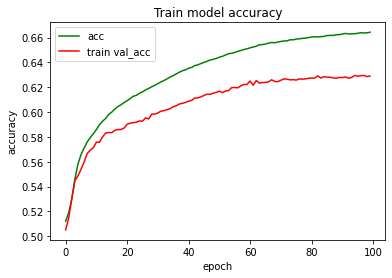

In [20]:
# Plotting the graphs
import matplotlib.pyplot as plt
plt.plot(history_train.history['acc'], color = 'green', label = 'acc')
plt.plot(history_train.history['val_acc'], color = 'red',label = 'train val_acc')
plt.title('Train model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

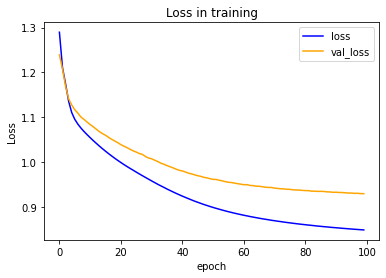

In [21]:
plt.plot(history_train.history['loss'], color = 'blue', label = 'loss')
plt.plot(history_train.history['val_loss'], color = 'orange',label = 'val_loss')
plt.title('Loss in training')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()